In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import glob
import os
import sys
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from time import time

import itertools
from sklearn.preprocessing import scale
from sklearn import preprocessing

import boto3
from io import BytesIO
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

In [ ]:
'''
-----------------------------------------------------------------------------
--- Inputs
-----------------------------------------------------------------------------
'''
Interp = 'NoInterp'
Analysis = 'DEC_Simple'
dataSource = 'L6'
Coor = 'Char'
dataSetName = '{}dataScaled.csv'.format(dataSource)
DRrange = range(1,2,1)

'''
-----------------------------------------------------------------------------
--- Definitions
-----------------------------------------------------------------------------
'''
Results = 'Results'
Indicies = 'Indicies'
Response = 'Response'
Figures = 'Figures'

# Configuring S3
s3_bucket_name = 'jasper-ml-sagemaker'
role = get_execution_role()

client = boto3.client('s3')
resource = boto3.resource('s3')
my_bucket = resource.Bucket(s3_bucket_name)

In [3]:
'''
-----------------------------------------------------------------------------
--- Importing Base Data
-----------------------------------------------------------------------------
'''
dataPath = 'Data/'

# Dataset
dataKey = 'scaledData.csv'
obj = client.get_object(Bucket=s3_bucket_name, Key=dataPath + dataKey)
dataSet = pd.read_csv(obj['Body'], header=None, index_col=None)

# Response Data
dataKey = '{}FixedResponse.npy'.format(dataSource)
obj = client.get_object(Bucket=s3_bucket_name, Key=dataPath + dataKey)
responseData = np.load(BytesIO(obj['Body'].read()))

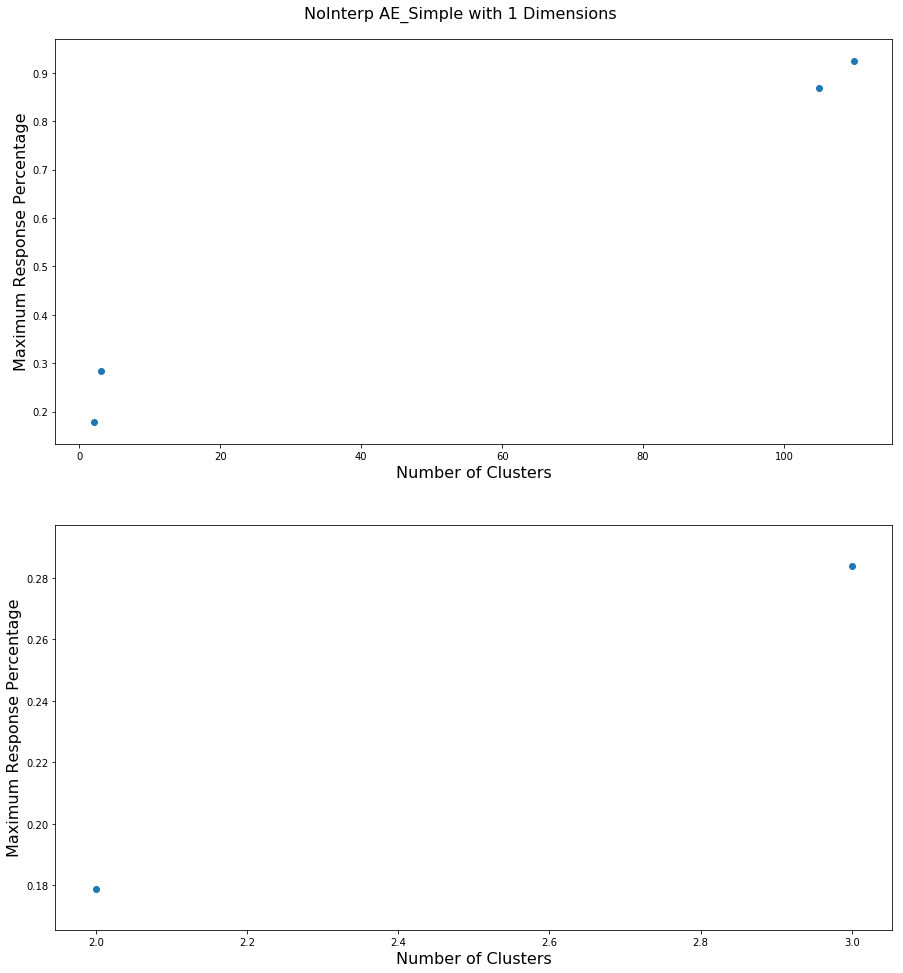

In [4]:
'''
-----------------------------------------------------------------------------
--- Loop for Multiple Dimensions
-----------------------------------------------------------------------------
'''

for Dimensions in DRrange:
        
    '''
    -----------------------------------------------------------------------------
    --- Importing Characteristic Indicies
    -----------------------------------------------------------------------------
    '''
    
    indiciesPath = '{}/{}/{}/{}/{}/'.format(dataSource, Coor, Interp, Analysis, Indicies)
    dataKey = '{}DimCharIndicies.npy'.format(Dimensions)
    
    obj = client.get_object(Bucket=s3_bucket_name, Key=indiciesPath + dataKey)
    collectedIndicies = np.load(BytesIO(obj['Body'].read()))

    '''
    -----------------------------------------------------------------------------
    --- Calculating Max Response
    -----------------------------------------------------------------------------
    '''
    charResponses = []
    for j in range(len(collectedIndicies)):
        responses = []
        for index in collectedIndicies[j]:
            responses.append(responseData[index])
        charResponses.append(responses)


    maxResponses = []
    centres = [len(x) for x in collectedIndicies]
    for j in range(len(charResponses)):
        maxResponses.append(max(charResponses[j]))

    # Formating Responses
    results = []
    results.append(np.flip(centres, axis=0))
    results.append(np.flip(maxResponses, axis=0))

    results = pd.DataFrame(results, ['centres','maxResponse']).transpose()
    results['responsePercentage'] = (results['maxResponse']- min(responseData))/(max(responseData)-min(responseData))

    # Uploading Responses
    responsePath = '{}/{}/{}/{}/{}/'.format(dataSource, Coor, Interp, Analysis, Response)
    dataKey = '{}DimResponses.npy'.format(Dimensions)

    np.save(dataKey,collectedIndicies)
    my_bucket.upload_file(dataKey,Key=responsePath + dataKey)
    os.remove(dataKey)

    '''
    -----------------------------------------------------------------------------
    --- Plotting Response vs No Centres
    -----------------------------------------------------------------------------
    '''

    # Plotting Responses

    fig, axs = plt.subplots(2,1,figsize=(15,15))
    fig.suptitle('{} {} with {} Dimensions'.format(Interp, Analysis, Dimensions), fontsize = 16)
    fig.subplots_adjust(top=0.95)
    axs[0].scatter(results.centres,results.responsePercentage)
    axs[0].set_xlabel('Number of Clusters', fontsize = 16)
    axs[0].set_ylabel('Maximum Response Percentage', fontsize = 16)

    axs[1].scatter(results.centres[results.centres < 100], results.responsePercentage[results.centres < 100])
    axs[1].set_xlabel('Number of Clusters', fontsize = 16)
    axs[1].set_ylabel('Maximum Response Percentage', fontsize = 16)

    # Uploading 
    figuresPath = '{}/'.format(Figures)
    dataKey = '{}{}With{}.png'.format(Interp,Analysis,Dimensions)

    plt.savefig(dataKey)
    my_bucket.upload_file(dataKey,Key=figuresPath + dataKey)
    os.remove(dataKey)

    plt.show()